# Import librairies

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_selection import SelectKBest, chi2
from nltk.tokenize import word_tokenize, sent_tokenize
import nltk
import numpy as np
import preprocessing.preprocessing as pp
from sklearn.model_selection import GridSearchCV

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Load datas

In [21]:
df = pp.load_data("english_cleaned_lyrics.csv")
df = pp.preprocess_data(df)
df = df[['lyrics', 'genre']]

print(df)

                                                   lyrics    genre
0       oh baby know im gonna cut right chase woman ma...      Pop
1       playin everything easy like seem sure still wa...      Pop
2       search tenderness isnt hard find love need liv...      Pop
3       oh oh oh oh oh oh wrote book stand title book ...      Pop
4       party people people party popping sitting arou...      Pop
...                                                   ...      ...
218205  gotta say boy couple date youre hand outright ...  Country
218206  helped find diamond ring made try everything t...  Country
218207  look couple corner booth look lot like shes lo...  Country
218208  fly mortal earth im measured depth girth fathe...  Country
218209  heard friend friend friend finally got rid gir...  Country

[218210 rows x 2 columns]


# Reduce number of rock songs

In [39]:
# Too many rocks songs, let's reduce the number of rock songs
df = df[~(df['genre'] == 'Other')]

rocks_indices = df[df['genre'] == 'Rock'].index

num_rocks_to_keep = 30000
num_rocks_current = len(rocks_indices)

print(num_rocks_current, num_rocks_to_keep)

if num_rocks_current > num_rocks_to_keep:
    keep_indices = np.random.choice(rocks_indices, num_rocks_to_keep, replace=False)
else:
    keep_indices = rocks_indices

df = df.drop(index=set(rocks_indices) - set(keep_indices))

30000 30000


In [40]:
X = df['lyrics']
y = df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [41]:

#model = make_pipeline(CountVectorizer(ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(TfidfVectorizer(stop_words='english', ngram_range=(1,3), max_features=10000), MultinomialNB(alpha=0.05))
#model = make_pipeline(CountVectorizer(ngram_range = (1,1), stop_words = en_stop), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=word_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=lemma_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (2,2)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=char_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (1,1)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (2,2)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=byte_tokenize, ngram_range = (3,3)), MultinomialNB())
#model = make_pipeline(CountVectorizer(tokenizer=gpt_tokenize, ngram_range = (3,3)), MultinomialNB())

# Ensure the tokenizer returns a flat list of tokens
def tokenize_nltk(text):
    sentences = sent_tokenize(text)
    tokens = [word for sentence in sentences for word in word_tokenize(sentence)]
    return tokens

"""
model = Pipeline([
    ('vectorizer', TfidfVectorizer(tokenizer=tokenize_nltk, stop_words='english', ngram_range=(1, 2))),
    ('feature_selection', SelectKBest(chi2, k=5000)),
    ('nb', MultinomialNB(alpha=0.01))
])
"""

model = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=tokenize_nltk, 
        stop_words='english', 
        ngram_range=(1, 1),
        max_features=20000
    )),
    ('nb', MultinomialNB(alpha=0.001))
])

In [42]:
# Parameters for Grid Search
parameters = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 3)],
    'vectorizer__max_features': [5000, 10000, 20000],
    'nb__alpha': [0.001, 0.01, 0.1, 1]
}

# Setup GridSearchCV
grid_search = GridSearchCV(model, parameters, cv=5, scoring='accuracy')

# Execute search
grid_search.fit(X_train, y_train, nb__sample_weight=sample_weights)

# Display results
print("Best Params:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)
y_pred = grid_search.predict(X_test)
print('Test Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

nb_classifier = grid_search.best_estimator_.named_steps['nb']
cm = confusion_matrix(y_test, y_pred, labels=nb_classifier.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=nb_classifier.classes_)
disp.plot()
plt.show()


/root/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/root/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


KeyboardInterrupt: 

In [25]:
model.fit(X_train, y_train, nb__sample_weight=sample_weights)
#model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/root/.pyenv/versions/3.10.5/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [26]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.48495238095238097
              precision    recall  f1-score   support

     Country       0.48      0.54      0.51      2725
  Electronic       0.20      0.21      0.21      1363
        Folk       0.12      0.19      0.14       374
     Hip-Hop       0.71      0.81      0.76      4492
       Indie       0.10      0.21      0.14       603
        Jazz       0.35      0.47      0.40      1498
       Metal       0.66      0.73      0.69      4261
         Pop       0.52      0.40      0.45      6854
         R&B       0.12      0.27      0.16       664
        Rock       0.44      0.28      0.34      6041

    accuracy                           0.48     28875
   macro avg       0.37      0.41      0.38     28875
weighted avg       0.50      0.48      0.48     28875



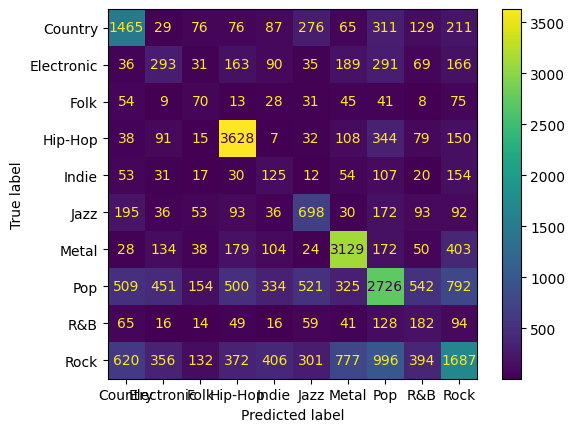

In [27]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)   
disp.plot()
plt.show()

In [28]:
lyrics = df['lyrics'][10]
genre = df['genre'][10]
print(genre)

preprocessed_lyrics = [lyrics.lower()]

predicted_genre = model.predict(preprocessed_lyrics)

print("Le genre prédit pour les paroles données est :", predicted_genre[0])

Pop
Le genre prédit pour les paroles données est : Rock


# Let's try our model with another genre distribution

In [29]:
df = pp.adjust_genre_distribution(df)
df

,lyrics,genre
0,oh baby know im gonna cut right chase woman ma...,Pop
1,playin everything easy like seem sure still wa...,Pop
2,search tenderness isnt hard find love need liv...,Pop
3,oh oh oh oh oh oh wrote book stand title book ...,Pop
4,party people people party popping sitting arou...,Pop
...,...,...
218205,gotta say boy couple date youre hand outright ...,Country/Folk
218206,helped find diamond ring made try everything t...,Country/Folk
218207,look couple corner booth look lot like shes lo...,Country/Folk
218208,fly mortal earth im measured depth girth fathe...,Country/Folk


In [30]:
X = df['lyrics']
y = df['genre']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

In [32]:
from nltk.tokenize import word_tokenize, sent_tokenize

# Ensure the tokenizer returns a flat list of tokens
def tokenize_nltk(text):
    sentences = sent_tokenize(text)
    tokens = [word for sentence in sentences for word in word_tokenize(sentence)]
    return tokens

model = Pipeline([
    ('vectorizer', TfidfVectorizer(
        tokenizer=tokenize_nltk, 
        stop_words='english', 
        ngram_range=(1, 1),
        max_features=20000
    )),
    ('nb', MultinomialNB(alpha=0.001))
])

In [36]:
model.fit(X_train, y_train, nb__sample_weight=sample_weights)
#model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5406179298642534
                        precision    recall  f1-score   support

          Country/Folk       0.46      0.53      0.49      3091
                  Jazz       0.34      0.51      0.41      1513
                 Metal       0.65      0.75      0.70      4219
                   Pop       0.48      0.49      0.49      6808
R&B/Hip-Hop/Electronic       0.73      0.63      0.68      6682
                  Rock       0.45      0.36      0.40      5975

              accuracy                           0.54     28288
             macro avg       0.52      0.55      0.53     28288
          weighted avg       0.55      0.54      0.54     28288



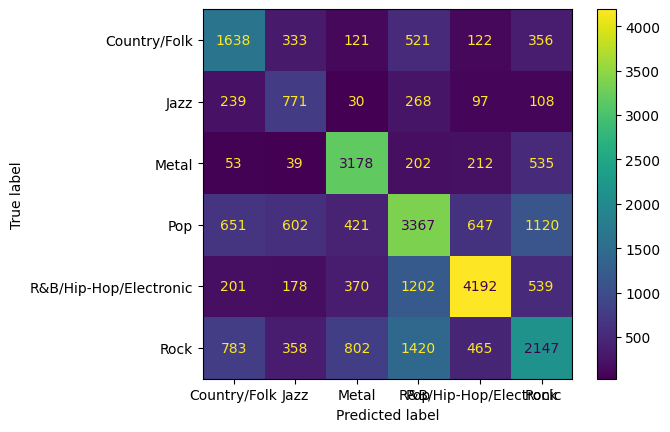

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=model.classes_)
disp.plot()
plt.show()

In [ ]:
lyrics = df['lyrics'][10]
genre = df['genre'][10]
print(genre)

preprocessed_lyrics = [lyrics.lower()]

predicted_genre = model.predict(preprocessed_lyrics)

print("Le genre prédit pour les paroles données est :", predicted_genre[0])

Pop
Le genre prédit pour les paroles données est : Rock
